## Exercise Sheet 1: Recurrent Models

Compare Vanilla Recurrent Neural Networks (RNN) with Long-Short Term Networks (LSTM). Implement a vanilla RNN and LSTM from scratch.

In [ ]:
import json
import os
import time
import math
import sys
import numpy as np
from numpy import sqrt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.functional as F

# import RNN from torch
from torch.nn import RNN

import matplotlib.pyplot as plt
%matplotlib inline

# set seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set paths
data_path = './data/'
model_path = './model/'
results_path = './results/'

# make directories if they don't exist
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(model_path):
    os.makedirs(model_path)
if not os.path.exists(results_path):
    os.makedirs(results_path)


# Data
p1 = [5, 10, 15, 20]
p2_acc_rnn = []
p3_acc_lstm = []

# Hyperparameters
config = {
    "input_length": 12,
    "input_dim": 1,
    "num_classes": 10,
    "num_hidden": 128,
    "batch_size": 128,
    "learning_rate": 0.001,
    "train_steps": 10000,
    "test_steps": 100,
    "max_norm": 1.0
}

# save config
with open(model_path + 'config.json', 'w') as file:
    json.dump(config, file)

### Task 1: Toy Problem: Palindrome Numbers

Use a  a recurrent neural network to predict the next digit of the palindrome
at every timestep. This can become difficult for very long sequences since the network has to memorise information from very far away earlier timesteps. Goal is to study the memoization capability of recurrent networks.

In [ ]:
class PalindromeDataset(data.Dataset):
    """ Randomly generates palindromes of a given length.
        The input is the first N-1 digits of the palindrome, the target is the last digit.
        For short palindromes, the number of possible palindromes is limited.
    """
    def __init__(self, seq_length):
        self.seq_length = seq_length

    def __len__(self):
        # Number of possible palindroms can be very big:
        # (10**(seq_length/2) or (10**((seq_length+1)/2)
        # Therefore we return the maximum integer value
        return sys.maxsize

    def __getitem__(self, idx):
        # Keep last digit as target label. Note: one-hot encoding for inputs is
        # more suitable for training, but this also works.
        full_palindrome = self.generate_palindrome()
        # Split palindrome into inputs (N-1 digits) and target (1 digit)
        return full_palindrome[0:-1], int(full_palindrome[-1])

    def generate_palindrome(self):
        # Generates a single, random palindrome number of 'length' digits.
        left = [np.random.randint(0, 10) for _ in range(math.ceil(self.seq_length / 2))]
        left = np.asarray(left, dtype=np.float32)
        right = np.flip(left, 0) if self.seq_length % 2 == 0 else np.flip(left[:-1], 0)
        return np.concatenate((left, right))


**Question 1.1**
\begin{aligned}
\frac{\partial L_{t}}{\partial W_{hh}} = \frac{\partial L_{t}}{\partial h_{t}} \frac{\partial h_{t}}{\partial h_{t-1} } \dots \frac{\partial h_{1}}{\partial W_{hh}} \\
= \frac{\partial L_{t}}{\partial h_{t}}(\prod_{t=2}^{T} \frac{\partial h_{t}}{\partial  h_{t-1}})\frac{\partial h_{1}}{\partial W_{hh}} \\
= \frac{\partial L_{t}}{\partial h_{t}}(\prod_{t=2}^{T}  softmax^{'}(W_{hh}h_{t-1} + W_{xh}x_t)W_{hh}^{T-1})\frac{\partial h_{1}}{\partial W_{hh}} \\
\end{aligned}

Difference in temporal dependence of both gradients.

In [ ]:
class VanillaRNN(nn.Module):

    def __init__(
        self, seq_length, input_dim, num_hidden, num_classes, batch_size, device=None):
        super(VanillaRNN, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Define the RNN layer
        self.hidden_state = torch.zeros(self.batch_size, self.num_hidden)
        self.W_hx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))      # input to hidden
        self.W_hh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))     # hidden to hidden
        self.B_h = nn.Parameter(torch.Tensor(self.num_hidden))                       # hidden bias
        # Define the output layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))    # hidden to output
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))                      # output bias

        # Initialize weights
        self.init_weights()

    def forward(self, x):
        # Initialize hidden state
        h_t = torch.zeros(self.num_hidden)

        for t in range(self.seq_length): # iterate over the time steps
            x_t = x[:, t].view(128,-1)
            h_t = torch.tanh(x_t @ self.W_hx + h_t @ self.W_hh + self.B_h)

        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Initialize weights to avoid gradients vanishing or exploding.
            Source: https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-2/

        """
        # Initialize weights with uniform distribution
        n_hx = self.W_hx.size(0)  # number of incoming connections for W_hx
        nn.init.uniform_(self.W_hx, -1 / sqrt(n_hx), 1 / sqrt(n_hx))

        n_hh = self.W_hh.size(0)  # number of incoming connections for W_hh
        nn.init.uniform_(self.W_hh, -1 / sqrt(n_hh), 1 / sqrt(n_hh))

        n_ph = self.W_ph.size(0)  # number of incoming connections for W_ph
        nn.init.uniform_(self.W_ph, -1 / sqrt(n_ph), 1 / sqrt(n_ph))

        # Initialize biases to zeros
        nn.init.zeros_(self.B_h)
        nn.init.zeros_(self.B_y)


    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [ ]:
def compute_accuracy(outputs, targets):
    """ Compute the accuracy of the model's predictions."""
    # Compute accuracy of outputs compared to targets
    _, predicted = torch.max(outputs, 1)
    correct = predicted.eq(targets)
    return 100 * correct.sum().item() / targets.size(0)

In [ ]:

def train(config:json, input_length=5, type='RNN', device=None):
    """ Train the model on the training set.
        Returns the trained model, losses and accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if input_length == 0:
        input_length = config['input_length']

    # Initialize the model that we are going to use
    if type == 'RNN':
        model = VanillaRNN(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    elif type == 'LSTM':
        model = LSTM(input_length, config['input_dim'], config['num_hidden'], config['num_classes'], config['batch_size'])
    else:
        raise ValueError('Model type not supported')

    model.to(device)
    model.train()

    # Initialize the dataset and data loader (note the +1)
    dataset = PalindromeDataset(input_length + 1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])

    # Train the model
    losses = []
    accuracies = []
    loss = 0.0

    for i, (inputs, targets) in enumerate(data_loader, 0):

        # Only for time measurement of step through network
        t1 = time.time()
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass, backward pass, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])

        loss += loss.item()
        accuracy = 0.0

        # Print statistics
        if i % 10 == 0:
            # Just for time measurement
            t2 = time.time()
            # print accuracy/loss here
            accuracy = compute_accuracy(outputs, targets)
            accuracies.append(accuracy)
            print('[step: %5d] loss: %.4f acc: %.4f time: %5d' %
                          (i, loss / 10, accuracy, t2-t1 / 10))
            losses.append(loss.detach().numpy() / 10)
            loss = 0.0

        if i == config['train_steps']:
            # If you receive a PyTorch data-loader error, check this bug report:
            # https://github.com/pytorch/pytorch/pull/9655
            break

    print('Finished Training')
    return model, losses, accuracies


def test(model, config:json, input_length=5, device=None):
    """ Test the model on the test set.
        Returns the accuracies.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if input_length == 0:
        input_length = config['input_length']

    # Initialize the dataset and data loader (leave the +1)
    dataset = PalindromeDataset(input_length+1)
    data_loader = data.DataLoader(dataset, config['batch_size'], num_workers=0)

    model.to(device)
    model.eval()

    # Test the model
    accuracies = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader, 0):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            accuracy = 0.0
            if i % 10 == 0:
                accuracy = compute_accuracy(outputs, targets)
                accuracies.append(accuracy)
                print('Accuracy: %.4f' % accuracy)

            if i == config['test_steps']:
                break

    print('Finished Testing')
    return accuracies


In [ ]:
# Load the configuration
with open(model_path + 'config.json', 'r') as file:
    config = json.load(file)

In [ ]:
def plot_loss(losses, title='Training Loss', path=None):
    """ Plot the losses of the model."""
    if path is None:
        path = results_path + 'training_loss.png'
    plt.plot(losses)
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title(title)
    plt.savefig(path)
    plt.show()

def plot_accuracy(accuracies, title='Training Accuracy', path=None):
    """ Plot the accuracies of the model."""
    if path is None:
        path = results_path + 'training_accuracy.png'
    plt.plot(accuracies)
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.savefig(path)
    plt.show()


#### Train and evaluate model on Palindromes with length N = 11

In [ ]:
# Train the model on T=5
model, losses, accuracies = train(config, input_length=p1[0], type='RNN', device=device)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=5]', path=results_path + 'training_loss_5_rnn.png')

# Plot accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=5]', path=results_path + 'training_accuracy_5_rnn.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[0], config=config, device=device)

# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

In [ ]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=5]', path=results_path + 'test_accuracy_5_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 2: Vanilla RNN in PyTorch

In [ ]:
# Train the model on T=10
model, losses, accuracies = train(config, input_length=p1[1], type='RNN', device=device)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=10]', path=results_path + 'training_loss_10_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=10]', path=results_path + 'training_accuracy_10_rnn.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[1], config=config, device=device)

In [ ]:
# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=10]', path=results_path + 'test_accuracy_10_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model on T=15
model, losses, accuracies = train(config, input_length=p1[2], type='RNN', device=device)

# Plot the losses
plot_loss(losses, title='Training Loss [N=15]', path=results_path + 'training_loss_15_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=15]', path=results_path + 'training_accuracy_15_rnn.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[2], config=config, device=device)

# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

In [ ]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=15]', path=results_path + 'test_accuracy_15_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model on T=20
model, losses, accuracies = train(config, input_length=p1[3], type='RNN', device=device)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=20]', path=results_path + 'training_loss_20_rnn.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=20]', path=results_path + 'training_accuracy_20_rnn.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[3], config=config, device=device)

# Add accuracies
p2_acc_rnn.append(np.mean(test_accuracies))

In [ ]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=20]', path=results_path + 'test_accuracy_20_rnn.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

### Task 3: Long-Short Term Network (LSTM) in PyTorch

In [ ]:
class LSTM(nn.Module):

    def __init__(self, seq_length, input_dim, num_hidden, num_classes, batch_size=128, device=None):
        super(LSTM, self).__init__()

        self.seq_length = seq_length
        self.input_dim = input_dim
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.batch_size = batch_size

        if device is None:
          device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.device = device

        # Hidden Layer
        self.W_gx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_gh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_g = nn.Parameter(torch.Tensor(self.num_hidden))

        # Cell State
        # (1) Input gate
        self.W_ix = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_ih = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_i = nn.Parameter(torch.Tensor(self.num_hidden))

        # (2) Forget gate
        self.W_fx = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_fh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_f = nn.Parameter(torch.Tensor(self.num_hidden))

        # (3) Output gate
        self.W_ox = nn.Parameter(torch.Tensor(self.input_dim, self.num_hidden))
        self.W_oh = nn.Parameter(torch.Tensor(self.num_hidden, self.num_hidden))
        self.B_o = nn.Parameter(torch.Tensor(self.num_hidden))

        # Output Layer
        self.W_ph = nn.Parameter(torch.Tensor(self.num_hidden, self.num_classes))
        self.B_y = nn.Parameter(torch.Tensor(self.num_classes))

        # Initialize weights
        self.init_weights()


    def forward(self, x):
        # Initialize hidden state and cell state
        h_t = torch.zeros(self.batch_size, self.num_hidden, device=self.device)
        c_t = torch.zeros(self.batch_size, self.num_hidden, device=self.device)

        for t in range(self.seq_length):
            x_t = x[:, t].view(self.batch_size, -1)

            # Compute the hidden state
            g_t = torch.tanh(x_t @ self.W_gx + h_t @ self.W_gh + self.B_g)
            i_t = torch.sigmoid(x_t @ self.W_ix + h_t @ self.W_ih + self.B_i)
            f_t = torch.sigmoid(x_t @ self.W_fx + h_t @ self.W_fh + self.B_f)
            o_t = torch.sigmoid(x_t @ self.W_ox + h_t @ self.W_oh + self.B_o)

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)

        # Compute the output
        output = h_t @ self.W_ph + self.B_y
        y = torch.softmax(output, dim=1)
        return y

    def init_weights(self):
        """ Initialize weights to avoid gradients vanishing or exploding.
            Source: https://dennybritz.com/posts/wildml/recurrent-neural-networks-tutorial-part-2/
        """
        n_gx = self.W_gx.size(0)
        nn.init.uniform_(self.W_gx, -1 / sqrt(n_gx), 1 / sqrt(n_gx))
        n_gh = self.W_gh.size(0)

        nn.init.uniform_(self.W_gh, -1 / sqrt(n_gh), 1 / sqrt(n_gh))
        n_ix = self.W_ix.size(0)
        nn.init.uniform_(self.W_ix, -1 / sqrt(n_ix), 1 / sqrt(n_ix))

        n_ih = self.W_ih.size(0)
        nn.init.uniform_(self.W_ih, -1 / sqrt(n_ih), 1 / sqrt(n_ih))
        n_fx = self.W_fx.size(0)
        nn.init.uniform_(self.W_fx, -1 / sqrt(n_fx), 1 / sqrt(n_fx))

        n_fh = self.W_fh.size(0)
        nn.init.uniform_(self.W_fh, -1 / sqrt(n_fh), 1 / sqrt(n_fh))
        n_ox = self.W_ox.size(0)
        nn.init.uniform_(self.W_ox, -1 / sqrt(n_ox), 1 / sqrt(n_ox))

        n_oh = self.W_oh.size(0)
        nn.init.uniform_(self.W_oh, -1 / sqrt(n_oh), 1 / sqrt(n_oh))
        n_ph = self.W_ph.size(0)
        nn.init.uniform_(self.W_ph, -1 / sqrt(n_ph), 1 / sqrt(n_ph))

        nn.init.zeros_(self.B_g)
        nn.init.zeros_(self.B_i)
        nn.init.zeros_(self.B_f)
        nn.init.zeros_(self.B_o)
        nn.init.zeros_(self.B_y)


    def init_hidden(self):
        # Initialize hidden state
        self.hidden_state = torch.zeros(self.batch_size, self.self.num_hidden, device=self.device)

    def set_grad(self, requires_grad):
        # Set requires_grad for all parameters
        for param in self.parameters():
            param.requires_grad = requires_grad

In [ ]:
# Train the model T=5
model, losses, accuracies = train(config, input_length=p1[0], type='LSTM', device=device)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=5]', path=results_path + 'training_loss_5_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=5]', path=results_path + 'training_accuracy_5_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[0], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

In [ ]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=5]', path=results_path + 'test_accuracy_5_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [52]:
# Train the model T=10
model, losses, accuracies = train(config, input_length=p1[1], type='LSTM', device=device)

[step:     0] loss: 0.4603 acc: 14.0625 time: 1547313501


<ipython-input-29-669a11e05986>:52: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4612 acc: 13.2812 time: 1547313501
[step:    20] loss: 0.4619 acc: 8.5938 time: 1547313502
[step:    30] loss: 0.4585 acc: 12.5000 time: 1547313502
[step:    40] loss: 0.4590 acc: 10.9375 time: 1547313502
[step:    50] loss: 0.4488 acc: 27.3438 time: 1547313502
[step:    60] loss: 0.4478 acc: 21.8750 time: 1547313503
[step:    70] loss: 0.4490 acc: 15.6250 time: 1547313503
[step:    80] loss: 0.4581 acc: 11.7188 time: 1547313503
[step:    90] loss: 0.4581 acc: 11.7188 time: 1547313504
[step:   100] loss: 0.4562 acc: 10.9375 time: 1547313504
[step:   110] loss: 0.4241 acc: 31.2500 time: 1547313504
[step:   120] loss: 0.4183 acc: 40.6250 time: 1547313504
[step:   130] loss: 0.4371 acc: 21.8750 time: 1547313505
[step:   140] loss: 0.4062 acc: 54.6875 time: 1547313505
[step:   150] loss: 0.4163 acc: 41.4062 time: 1547313505
[step:   160] loss: 0.4048 acc: 51.5625 time: 1547313506
[step:   170] loss: 0.4172 acc: 39.0625 time: 1547313506
[step:   180] loss: 0.4160 acc: 

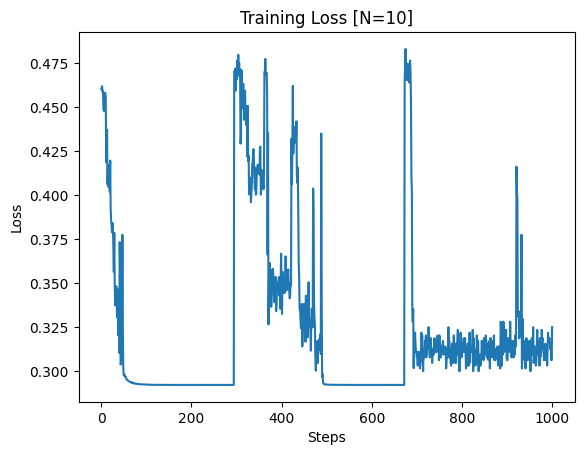

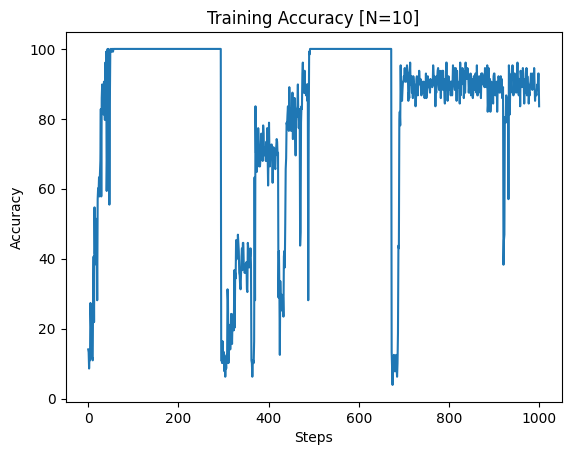

In [53]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=10]', path=results_path + 'training_loss_10_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=10]', path=results_path + 'training_accuracy_10_lstm.png')

In [54]:
# Test the model
test_accuracies = test(model, input_length=p1[1], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

Accuracy: 91.4062
Accuracy: 91.4062
Accuracy: 89.0625
Accuracy: 90.6250
Accuracy: 90.6250
Accuracy: 92.1875
Accuracy: 91.4062
Accuracy: 89.0625
Accuracy: 85.1562
Accuracy: 96.0938
Accuracy: 87.5000
Finished Testing


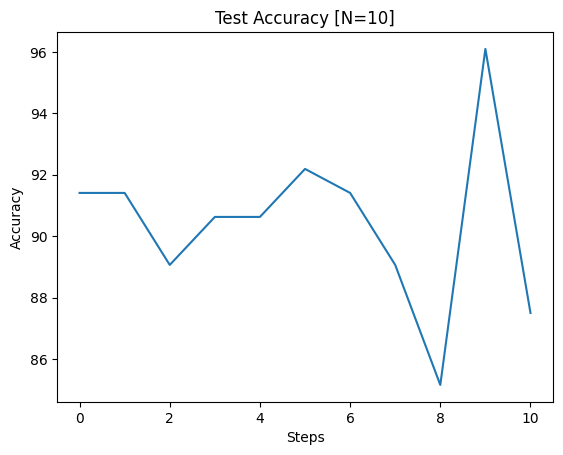

Average test accuracy: 90.41%


In [55]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=10]', path=results_path + 'test_accuracy_10_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model T=15
model, losses, accuracies = train(config, input_length=p1[2], type='LSTM', device=device)

[step:     0] loss: 0.4614 acc: 9.3750 time: 1547313826


<ipython-input-29-669a11e05986>:52: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(model.parameters(), max_norm=config['max_norm'])


[step:    10] loss: 0.4614 acc: 11.7188 time: 1547313826
[step:    20] loss: 0.4612 acc: 10.9375 time: 1547313827
[step:    30] loss: 0.4609 acc: 9.3750 time: 1547313827
[step:    40] loss: 0.4604 acc: 10.9375 time: 1547313828
[step:    50] loss: 0.4603 acc: 10.9375 time: 1547313828
[step:    60] loss: 0.4613 acc: 9.3750 time: 1547313829
[step:    70] loss: 0.4615 acc: 7.0312 time: 1547313829
[step:    80] loss: 0.4604 acc: 10.9375 time: 1547313829
[step:    90] loss: 0.4602 acc: 12.5000 time: 1547313830
[step:   100] loss: 0.4614 acc: 5.4688 time: 1547313830
[step:   110] loss: 0.4608 acc: 11.7188 time: 1547313831
[step:   120] loss: 0.4599 acc: 13.2812 time: 1547313831
[step:   130] loss: 0.4608 acc: 7.0312 time: 1547313832
[step:   140] loss: 0.4603 acc: 17.1875 time: 1547313832
[step:   150] loss: 0.4604 acc: 10.1562 time: 1547313833
[step:   160] loss: 0.4609 acc: 10.1562 time: 1547313834
[step:   170] loss: 0.4604 acc: 9.3750 time: 1547313834
[step:   180] loss: 0.4608 acc: 7.812

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=15]', path=results_path + 'training_loss_15_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=15]', path=results_path + 'training_accuracy_15_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[2], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

In [ ]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=15]', path=results_path + 'test_accuracy_15_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
# Train the model T=20
model, losses, accuracies = train(config, input_length=p1[3], type='LSTM', device=device)

In [ ]:
# Plot the losses
plot_loss(losses, title='Training Loss [N=20]', path=results_path + 'training_loss_20_lstm.png')

# Plot the accuracies
plot_accuracy(accuracies, title='Training Accuracy [N=20]', path=results_path + 'training_accuracy_20_lstm.png')

In [ ]:
# Test the model
test_accuracies = test(model, input_length=p1[3], config=config, device=device)

# Add accuracies
p3_acc_lstm.append(np.mean(test_accuracies))

In [ ]:
# plot the test accuracies
plot_accuracy(test_accuracies, title='Test Accuracy [N=20]', path=results_path + 'test_accuracy_20_lstm.png')

# Average accuracy over all Steps
print(f"Average test accuracy: {np.mean(test_accuracies):.2f}%")

In [ ]:
plt.title('Accuracy w.r.t. palindromes length.')
plt.plot(p1, p2_acc_rnn, color='red', label='RNN')
plt.scatter(p1, p2_acc_rnn, color='red')

plt.plot(p1, p3_acc_lstm, color='green', label='LSTM')
plt.scatter(p1, p3_acc_lstm, color='green')

plt.xlabel('Palindromes Length')
plt.ylabel('Accuracy')
plt.legend()
plt.show()